<a href="https://colab.research.google.com/github/Oliz888/DL_course/blob/main/chapter_linear-regression/oo-design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Object-Oriented Design for Implementation
:label:`sec_oo-design`

In our introduction to linear regression,
we walked through various components
including
the data, the model, the loss function,
and the optimization algorithm.
Indeed,
linear regression is
one of the simplest machine learning models.
Training it,
however, uses many of the same components that other models in this book require.
Therefore,
before diving into the implementation details
it is worth
designing some of the APIs
that we use throughout.
Treating components in deep learning
as objects,
we can start by
defining classes for these objects
and their interactions.
This object-oriented design
for implementation
will greatly
streamline the presentation and you might even want to use it in your projects.


Inspired by open-source libraries such as [PyTorch Lightning](https://www.pytorchlightning.ai/),
at a high level
we wish to have three classes:
(i) `Module` contains models, losses, and optimization methods;
(ii) `DataModule` provides data loaders for training and validation;
(iii) both classes are combined using the `Trainer` class, which allows us to
train models on a variety of hardware platforms.
Most code in this book adapts `Module` and `DataModule`. We will touch upon the `Trainer` class only when we discuss GPUs, CPUs, parallel training, and optimization algorithms.


In [3]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

NOTE


————————————————————

# **1 函式 (function)：單一動作的封裝**
- 只做一件事；
- 不帶狀態（或只靠傳入參數）


```
def f(x, y):
  return x + y
```

# **2 類別 (class)：把「資料 + 行為」綁在一起**

2.1 為什麼需要類別
- 你想同時保存狀態（屬性）又執行動作（方法）。
- 例子：神經網路層需保存權重 W、偏置 b，還要有 forward() 動作。

2.2 最小語法
```
class Counter:
    def __init__(self):      # 建構子，self 代表「這個實例」
        self.cnt = 0         # 實例屬性

    def add_one(self):       # 方法；self 可存取屬性
        self.cnt += 1
```
- 建立：c = Counter()
- 呼叫方法：c.add_one()
- 屬性值：c.cnt → 1

方法 (method) 就是「寫在類別裡、第一參數固定叫 self¹」的函式；呼叫時 Python 會自動把實例塞進去。
¹ 也可以叫別的名字，但大家都用 self。

# **3 方法種類：instance / class / static**
```
class Demo:
    val = 10                 # 類別屬性

    def inst(self):          # 實例方法
        return self.val + 1

    @classmethod
    def clz(cls):            # 類別方法
        return cls.val + 2

    @staticmethod
    def util(x):             # 靜態方法
        return x * 2
```
| 類型       | 第一參數   | 常見用途              |
| -------- | ------ | ----------------- |
| instance | `self` | 需要「該物件的屬性」時 (最常用) |
| class    | `cls`  | 工廠函式、修改整個類別屬性     |
| static   | 無      | 和類別邏輯相關，但不依賴任何屬性  |


# **4 為什麼「動態加方法」 (add_to_class)？**


```
def add_to_class(Class):          # 把目標類別當引數
    def wrapper(func):            # 真正的 decorator
        setattr(Class, func.__name__, func)  # 安裝成方法
        return func
    return wrapper                # 回傳 decorator

class A:                          # 先有類別
    b = 1

@add_to_class(A)                  # 之後再加方法
def do(self):
    print("b =", self.b)

A().do()   # → b = 1
```








In [4]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

class A:
    def __init__(self):
        self.b = 1

a = A()

@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [5]:
@add_to_class(A)
def foo(self, x):
    return x + 1

@add_to_class(A)
def bar(self, y):
    return y * 2


a.foo(2)
a.bar(5)

10

## Utilities
:label:`oo-design-utilities`

We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One of the challenges is that class definitions tend to be fairly long blocks of code. Notebook readability demands short code fragments, interspersed with explanations, a requirement incompatible with the style of programming common for Python libraries. The first
utility function allows us to register functions as methods in a class *after* the class has been created. In fact, we can do so *even after* we have created instances of the class! It allows us to split the implementation of a class into multiple code blocks.


In [6]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

Let's have a quick look at how to use it. We plan to implement a class `A` with a method `do`. Instead of having code for both `A` and `do` in the same code block, we can first declare the class `A` and create an instance `a`.


In [7]:
class A:
    def __init__(self):
        self.b = 1

a = A()

Next we define the method `do` as we normally would, but not in class `A`'s scope. Instead, we decorate this method by `add_to_class` with class `A` as its argument. In doing so, the method is able to access the member variables of `A` just as we would expect had it been included as part of `A`'s definition. Let's see what happens when we invoke it for the instance `a`.


In [8]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [9]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    def do(self):
      print('Class attribute "b" is', self.b)

The second one is a utility class that saves all arguments in a class's `__init__` method as class attributes. This allows us to extend constructor call signatures implicitly without additional code.


In [10]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

We defer its implementation into :numref:`sec_utils`. To use it, we define our class that inherits from `HyperParameters` and calls `save_hyperparameters` in the `__init__` method.


In [11]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The final utility allows us to plot experiment progress interactively while it is going on. In deference to the much more powerful (and complex) [TensorBoard](https://www.tensorflow.org/tensorboard) we name it `ProgressBoard`. The  implementation is deferred to :numref:`sec_utils`. For now, let's simply see it in action.

The `draw` method plots a point `(x, y)` in the figure, with `label` specified in the legend. The optional `every_n` smooths the line by only showing $1/n$ points in the figure. Their values are averaged from the $n$ neighbor points in the original figure.


In [12]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

In the following example, we draw `sin` and `cos` with a different smoothness. If you run this code block, you will see the lines grow in animation.


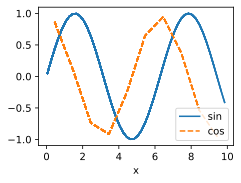

In [ ]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## Models
:label:`subsec_oo-design-models`

The `Module` class is the base class of all models we will implement. At the very least we need three methods. The first, `__init__`, stores the learnable parameters, the `training_step` method accepts a data batch to return the loss value, and finally, `configure_optimizers` returns the optimization method, or a list of them, that is used to update the learnable parameters. Optionally we can define `validation_step` to report the evaluation measures.
Sometimes we put the code for computing the output into a separate `forward` method to make it more reusable.


In [13]:
class Module(nn.Module, d2l.HyperParameters):

  ## the class inherits from two parents, nn.Module (Pytorch) brings in parameter registration and the "forward convention"
    """The base class of models."""
    ## constructor
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1): ## plot_train_per_epoch controls how many points per epoch you keeep plotting against loss, same for validation
        super().__init__() ## intialize BOTH parents, because of multiple inheritance, this actually both parent
        self.save_hyperparameters() ## stores ctor args
        self.board = ProgressBoard() ## animator object

    def loss(self, y_hat, y): ## yor must override this in a concrete subclass; otherwise the trainer will crash. Typical Choice: nn.CrossEntrophyLoss(), nn.MSELoss(), etc
        raise NotImplementedError

    def forward(self, X): ## contract - subclasses are expected to create self.net (e.g., nn.Sequential)
        assert hasattr(self, 'net'), 'Neural network is defined' ## this assert guards newcomers who forget to define it
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited' # trainer (injected later) keeps global training state: current epoch, batch idx, number of batches, etc
        self.board.xlabel = 'epoch'
        if train: ## choosing the x-coodinate (horizontal axis)
        ## if the case is the training loop
        ## x means fraction inside the current epoch, 0 -> 1, inition behind is that lets the animation shows a smooth cutver instead of one dot per epoch

        ## if the validation loop
        ## x means discrete epoch count (1,2,3... ) validation is done once per epoch so interger ticks are fine


        ## n tells the board how often to draw
        ## e.g. if you have 100 training batches, and plot_train_per_epoch = 2, then it draws every 50 batches  (twice per )
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))


        ## value.to(dl.cpu()).detach().numpy() - moves the loss tensor to CPU, stops autograd tracking, converts to Nump

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

        ## batch layout. - D2L's loaders pack data like (features, labels) or (x1, x2, ..., y)
        ## - batch [: -1] -> everything except the last element (inputs)
        ## - batch[-1] -> the last elements (targets)
        ## self(*inputs) - pythons 'splat" expands the tuple so this becomes the familiar self(X) or self(X1, X2) call , which tigers forward


    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l,  train=False)


        ## both steps logs the loss: and training_step returns the scalar loss so the trainer can call loss.backward()




    def configure_optimizers(self):
        raise NotImplementedError

      ## configure_optimizers: left abstract so subclasses can choose Adam, SGD., etc and pass the learning-rate schedules if desired

In [30]:
## a minimal concrete model might look like


class MLP(Module): ## 1. define a subclass of our custom Module
  def __init__(self, lr = 0.01): ## 2. construtor: lr becomes a hyper-parameter
    super().__init__() ## 3. run parent constructor  (nn.Module + Hyperparameter)
    self.save_hyperparameters() ## 4. Record lr so we can log/serialize it later

    ## 5 .build the neural network proper and store it in self.net
    self.net = nn.Sequential(
        nn.Flatten(), ## 6. Flatten 28*28 images to 784-D vectors
        nn.Linear(28*28, 256),  ## 7.fully-connected layer -> 256 hidden units, weight/bias are registered as parameters
        nn.ReLU(), ##8. non-linearity
        nn.Linear(256, 10) ##9.Output layer -> 10 logits (for 10 classes)
    )

    def loss(self, y_hat, y):
      return nn.functional.cross_entropy(y_hat, y)
       ## 10.overide the abstract loss() method



      ## 11. cross-entropy between predicted logits and interger labels
      return nn.functional.cross_entropy(y_hat, y)


    def configure_optimizers(self): ## 12. ZTell the trainer which optimize to use
      ## Classical SGD over *all* parameters returned by self.parameters()
      return torch.optim.SGD(self.parameters(), lr = self.lr)

trainer = d2l.Trainer(max_epochs=10)
model   = MLP(lr=0.05)
trainer.fit(model, train_iter, test_iter)

In [42]:
# import torch
# from torch import nn
# from d2l import torch as d2l             # for Module, Trainer, etc.

# # 1. Data --------------------------------------------------------------------
# batch_size = 256
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# # 2. Model -------------------------------------------------------------------
# class MLP(d2l.Module):
#     def __init__(self, lr=0.01):
#         super().__init__()
#         self.save_hyperparameters()
#         self.net = nn.Sequential(
#             nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 10)
#         )
#     def loss(self, y_hat, y):
#         return nn.functional.cross_entropy(y_hat, y)
#     def configure_optimizers(self):
#         return torch.optim.SGD(self.parameters(), lr=self.lr)

# # 3. Train -------------------------------------------------------------------
# model   = MLP(lr=0.05)
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, train_iter, test_iter)


| Case            | `x` means                                    | Intuition                                                            |
| --------------- | -------------------------------------------- | -------------------------------------------------------------------- |
| Training loop   | Fraction inside the current epoch, **0 → 1** | Lets the animation show a smooth curve instead of one dot per epoch. |
| Validation loop | Discrete epoch count (`1, 2, 3…`)            | Validation is done once per epoch so integer ticks are fine.         |


You may notice that `Module` is a subclass of `nn.Module`, the base class of neural networks in PyTorch.
It provides convenient features for handling neural networks. For example, if we define a `forward` method, such as `forward(self, X)`, then for an instance `a` we can invoke this method by `a(X)`. This works since it calls the `forward` method in the built-in `__call__` method. You can find more details and examples about `nn.Module` in :numref:`sec_model_construction`.


##  Data
:label:`oo-design-data`

The `DataModule` class is the base class for data. Quite frequently the `__init__` method is used to prepare the data. This includes downloading and preprocessing if needed. The `train_dataloader` returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the `training_step` method of `Module` to compute the loss. There is an optional `val_dataloader` to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the `validation_step` method in `Module`.


| Goal                            | How this class helps                                                                                                                                                                                                                          |
| ------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Unified data interface**      | Instead of handing a `Trainer` raw `DataLoader`s, the trainer asks the *module itself* for `train_dataloader()` and `val_dataloader()`.  This keeps model code and data code decoupled but still interoperable.                               |
| **Hyper-parameter tracking**    | By inheriting from `d2l.HyperParameters`, anything you pass to the constructor (e.g., `root`, `num_workers`, maybe `batch_size` in subclasses) is automatically stored in `self.hparams` and accessible via dot notation (e.g., `self.root`). |
| **Subclass-only customization** | `get_dataloader(self, train)` is an **abstract hook**.  You implement it once in a subclass (say, `FashionMNISTDataModule`) and the two convenience wrappers (`train_dataloader`, `val_dataloader`) work for free.                            |
| **Cleaner trainer API**         | A `Trainer` only needs a single argument `data`, not two separate loaders.  Internally it just calls `data.train_dataloader()` and `data.val_dataloader()`.                                                                                   |


In [43]:
class DataModule(d2l.HyperParameters):  ##Inherit logging/serialization helps
    """The base class of data."""
    def __init__(self,
                 root='../data',
                 num_workers=4): ## number of subprocesses for DataLoader
        self.save_hyperparameters()  ## Auto-stores root and number of works as attributes in self.hparams

    def get_dataloader(self, train): ## <-- Abstract hook: must return a PyTorch DataLoader
        raise NotImplementedError ## <-- Force subclass to override

    def train_dataloader(self): ## Convenience wrapper used by Trainer
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

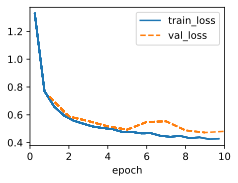

In [44]:
class FashionMNISTDataModule(DataModule):
    def __init__(self, batch_size=256, **kwargs):
        super().__init__(**kwargs)            # record root & num_workers
        self.batch_size = batch_size          # additional hyper-param

    def get_dataloader(self, train):
        from torchvision import datasets, transforms
        trans = transforms.ToTensor()
        ds = datasets.FashionMNIST(self.root, train=train, download=True, transform=trans)
        return torch.utils.data.DataLoader(ds,
                                           batch_size=self.batch_size,
                                           shuffle=train,
                                           num_workers=self.num_workers)



data   = FashionMNISTDataModule(root="../data", num_workers=2, batch_size=256)
model  = MLP(lr=0.05)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)   # Trainer grabs loaders via the two helper methods

| Term                             | One-liner intuition                                                                                            |
| -------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Epoch**                        | One full sweep through **every** example in the training set.                                                  |
| **Training loss (`train_loss`)** | “How wrong are we *on the data we just used to learn?*” – averaged over all mini-batches in the current epoch. |
| **Validation loss (`val_loss`)** | “How wrong are we on **new, unseen** data?” – computed on a held-out set only **after** the epoch finishes.    |




Think of the training set as your class notes and the validation set as a short practice quiz. During each epoch you study all the notes, then you shut the notebook and take the quiz once.--If you ace the class notes but keep bombing the quiz, you’re memorizing instead of learning (over-fitting).



Why two curves instead of one?
- Training loss should almost always decrease (or at least plateau) because the optimizer is explicitly minimizing it.

- Validation loss tells you whether those gains actually carry over to data the model never saw.

  - If it falls in tandem with training loss → you’re genuinely learning.

  - If it bottoms out then starts climbing while training loss keeps falling → the model is fitting noise (classic over-fitting signal).

Plotting them together lets you spot that divergence and decide when to stop, add regularization, collect more data, etc.



## Training
:label:`oo-design-training`


The `Trainer` class trains the learnable parameters in the `Module` class with data specified in `DataModule`. The key method is `fit`, which accepts two arguments: `model`, an instance of `Module`, and `data`, an instance of `DataModule`. It then iterates over the entire dataset `max_epochs` times to train the model. As before, we will defer the implementation of this method to later chapters.


In [ ]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    ## max_epochs: how many full passes over the training set
    ## num_gpus: placeholder for future CUDA support (current forced to 0)
    ## gradient_clip_val: will eventually cap gradient norm; stored even if unused.
    ## save_hyperparameters() copies all arguments into self.<name> and into the dict self.harapms for logging/serialization


    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
        ## given a DataModule: cache its loaders and pre-compute how many batches each has
        ## these length are later used for plotting (x = batch_idx/num_train_batches) and throttling log frequently

    def prepare_model(self, model):
        model.trainer = self ## give model a back-pointer
        model.board.xlim = [0, self.max_epochs] ## set plot's x-axis range
        self.model = model ## store for convenience

        ## back-pointer lets the model read self.epochm self.train_batch_idx, etc. inside its own plot() helper

    def fit(self, model, data):
        self.prepare_data(data) ## 1. set up loaders and counters
        self.prepare_model(model) ## 2.inject trainer reference
        self.optim = model.configure_optimizers() ## 3. optimize
        self.epoch = 0 ## 4. intialize epoch counter
        self.train_batch_idx = 0 ## 5. batch indexes for plots
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self): ## epoch loop
        raise NotImplementedError ## call hook

| Purpose                                 | What the `Trainer` does for you                                                                                                                                                                               |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Coordinates four moving parts**       | (1) the model, (2) the optimizer, (3) the training dataloader, (4) the validation dataloader.                                                                                                                 |
| **Abstracts boilerplate**               | You don’t manually loop over epochs/batches or keep track of batch indices; `Trainer` calls the model’s hooks (`training_step`, `validation_step`, etc.) and updates counters.                                |
| **Keeps hyper-parameters in one place** | By inheriting from `d2l.HyperParameters`, anything you pass to the constructor (e.g., `max_epochs`, `num_gpus`) is automatically recorded in `self.hparams` and as regular attributes (`self.max_epochs`, …). |
| **Links model ↔ data ↔ progress board** | `prepare_model()` injects a back-pointer (`model.trainer = self`) so the model can read epoch indexes for plotting.                                                                                           |
| **Pluggable**                           | Concrete trainers (e.g., one that supports GPUs or gradient accumulation) can inherit from this base and override `fit_epoch()` or `prepare_model()` without rewriting everything.                            |


## Summary

To highlight the object-oriented design
for our future deep learning implementation,
the above classes simply show how their objects
store data and interact with each other.
We will keep enriching implementations of these classes,
such as via `@add_to_class`,
in the rest of the book.
Moreover,
these fully implemented classes
are saved in the [D2L library](https://github.com/d2l-ai/d2l-en/tree/master/d2l),
a *lightweight toolkit* that makes structured modeling for deep learning easy.
In particular, it facilitates reusing many components between projects without changing much at all. For instance, we can replace just the optimizer, just the model, just the dataset, etc.;
this degree of modularity pays dividends throughout the book in terms of conciseness and simplicity (this is why we added it) and it can do the same for your own projects.


## Exercises

1. Locate full implementations of the above classes that are saved in the [D2L library](https://github.com/d2l-ai/d2l-en/tree/master/d2l). We strongly recommend that you look at the implementation in detail once you have gained some more familiarity with deep learning modeling.
1. Remove the `save_hyperparameters` statement in the `B` class. Can you still print `self.a` and `self.b`? Optional: if you have dived into the full implementation of the `HyperParameters` class, can you explain why?


[Discussions](https://discuss.d2l.ai/t/6646)
